In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm

#Code implementations derived from https://github.com/mimoralea/gdrl

In [2]:
class FCDAP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCDAP, self).__init__()
        self.activation_fc = activation_fc

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers,
            nn.Linear(hidden_dims[-1], output_dim)
        )

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
        
    def forward(self, state):
        x = self._format(state)
        return self.layers(x)

    #select and return action, corresponding log prob of the action, and entropy of the distribution
    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action).unsqueeze(-1), dist.entropy().unsqueeze(-1)

In [3]:
#fully connected actor critic neural network
class FCAC(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCAC, self).__init__()
        self.activation_fc = activation_fc

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers
        )

        self.policy_output = nn.Linear(hidden_dims[-1], output_dim)
        self.value_output = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
        
    def forward(self, state):
        x = self._format(state)
        out = self.layers(x)
        return self.policy_output(out), self.value_output(out)
    
    #select and return action, corresponding log prob of the action, entropy of the distribution, and value of state
    def select_action(self, state):
        logits, value = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action).unsqueeze(-1), dist.entropy().unsqueeze(-1), value

# Asynchronous advantage actor-critic (A3C)

[Original paper](https://arxiv.org/pdf/1602.01783.pdf)

[Implementation here](a3c.py)
- Uses action-advantage estimate ($A^{\pi}(s_t, a_t)$) like with VPG
- Advantage estimate uses n-step TD estimates instead of full episode returns
  - Introduces **critic** to model, since n-step TD estimate uses learning value function approximator
  - Less variance, but higher bias and worse convergence properties
- Multiple actor-critics run asynchronously to optimize a single shared model with the process loop:
  - Copy parameters $\theta$, $\theta_v$ from shared policy/value model
  - Interact with environment for $n$ steps, keeping track of state $s_t$, action $a_t$, and reward $r_t$ at each step
  - After $n$ steps, for each step $t$ in $T, T+1, ..., T+n$:
    - Calculate n-step TD estimate: $R^{(n)}_t = r_t + \gamma r_{t+1} + ... + \gamma^n r_{T+n} + V(s_{T+n+1};\theta_v)$
    - Calculate advantage estimate: $A^{(n)}_t = R^{(n)}_t - V(s_t;\theta_v)$
    - Calculate policy gradient: $\nabla_\theta J(\theta) = A^{(n)}_t \nabla_\theta \log \pi_(a_t|s_t;\theta)$
    - Calculate value estimator loss $\propto A_t^2$
  - Step and update shared policy/value parameters with policy gradient and value estimator loss

![Alt text](image.png)

In [25]:
import pickle
res = {}
with open('a3c.results', 'rb') as file:
    res = pickle.load(file)

In [26]:
res['best_moving_avg_return']

tensor([500.])

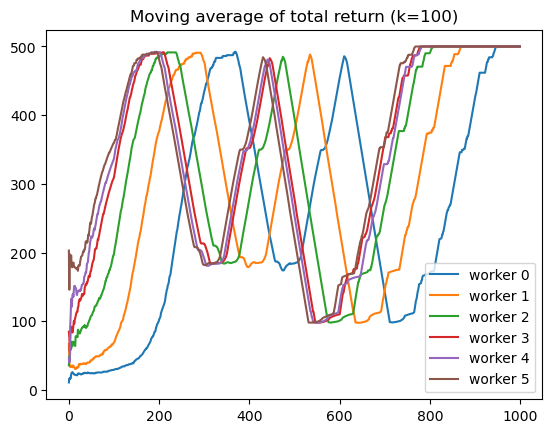

In [27]:
episode_returns = res['episode_returns']
for rank, returns_tensor in enumerate(episode_returns):
    plt.plot(range(len(returns_tensor)), [returns_tensor[max(0,x-100):x+1].mean() for x in range(len(returns_tensor))], label=f'worker {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [31]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, res['best_model'], num_episodes=1, stochastic=True)

[500.0]

In [30]:
env.close()

# Generalized advantage estimation (GAE)

[Original paper](https://arxiv.org/pdf/1506.02438.pdf)
- Recall the original n-step TD advantage estimate, for each step $t$ in $T, T+1, ..., T+n$:
  - Calculate n-step TD estimate: $R^{(n)}_t = r_t + \gamma r_{t+1} + ... + \gamma^n r_{T+n} + V(s_{T+n+1};\theta_v)$
  - Calculate advantage estimate: $A^{(n)}_t = R^{(n)}_t - V(s_t;\theta_v)$
- Let $A^{(1)}_t= -V(s_t) + r_t + \gamma V(s_{t+1})= \delta_t$:
  - $A^{(2)}_t=-V(s_t) + r_t + \gamma r_{t+1}+ \gamma^2 V(s_{t+2}) = (-V(s_t) + r_t + \gamma V(s_{t+1})) + (-\gamma V(s_{t+1})+\gamma r_{t+1}+ \gamma^2 V(s_{t+2})) = \delta_t + \gamma\delta_{t+1}$
  - $A^{(k)}_t=\sum_{l=0}^k \gamma^l \delta_{t+l}$
  - $\lim_{k\to\infty} A^{(k)}_t=\sum_{l=0}^\infty \gamma^l \delta_{t+l}=-V(s_t)+\sum_{l=0}^\infty\gamma^l r_{t+l}$ which is just the full Monte Carlo return minus value function baseline (VPG!)
- The generalized advantage estimator $A_t^{\text{GAE}(\lambda)}$ is the exponentially-weighted average of these n-step advantage estimates
  - $A_t^{\text{GAE}(\lambda)}=(1-\lambda)(A^{(1)}_t+\lambda A^{(2)}_t+...)=...=\sum_{l=0}^\infty(\gamma\lambda)^l \delta_{t+l}=\sum_{l=0}^\infty(\gamma\lambda)^l R^{(1)}_{t+l} - V(s_{t+l})$
  - $0<\lambda<1$ controls the bias and variance of the estimator
    - $\lambda\to 1$ (full n-step) lowers bias, but has higher variance
    - $\lambda\to 0$ (single-step) lowers variance, but induces bias

In [15]:
import pickle
res = {}
with open('a3c_gae.results', 'rb') as file:
    res = pickle.load(file)

In [16]:
res['best_moving_avg_return']

tensor([251.8812])

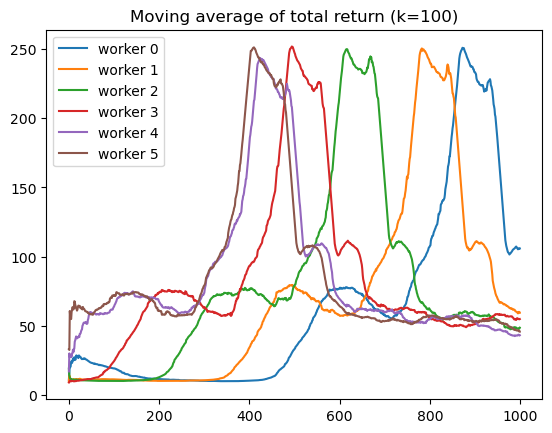

In [17]:
episode_returns = res['episode_returns']
for rank, returns_tensor in enumerate(episode_returns):
    plt.plot(range(len(returns_tensor)), [returns_tensor[max(0,x-100):x+1].mean() for x in range(len(returns_tensor))], label=f'worker {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [21]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, res['best_model'], num_episodes=1, stochastic=True)

[167.0]

In [19]:
env.close()